# Examples

In the present section, we use Gaussian process regression as well as Gaussian process classification in order to demonstrate briefly the application of scikit-learn.

We use the following [toy](https://scikit-learn.org/stable/datasets/toy_dataset.html) and [real-world](https://scikit-learn.org/stable/datasets/real_world.html) datasets provided by scikit-learn:

- [diabetes dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) for single-output regression
- [California housing dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) for multi-output regression
- [breast cancer dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-wisconsin-diagnostic-dataset) for binary classification
- [handwritten digits dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset) for multi-class classification

The scikit-learn website provides detailed information on the number of samples, the features, the labels and the specific task.

Each dataset is splitted into training and test data. Afterwards, the model is constructed from the training data and finally, the model quality of measured in use of the test data and a suitable metric.

## Diabetes Progression

The data contains information on 442 diabetes patients:
- 10 features are given (age, sex, BMI, average blood pressure as well as six blood serum measurements)
- the label is a quantitative measure of disease progression one year after baseline

In [1]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# load data
diabetes_dataset = load_diabetes()

X = diabetes_dataset["data"]
y = diabetes_dataset["target"].reshape(-1, 1)

# split data (80% train and 20% test)
# training: 353 samples, test: 89 samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale data
scalerX, scalery = StandardScaler(), StandardScaler()
X_train_ = scalerX.fit_transform(X_train)
y_train_ = scalery.fit_transform(y_train)

# construct GPR model

# scaled, anisotropic RBF kernel with noise
kernel = ConstantKernel() * RBF(length_scale= 10 * [1.0], length_scale_bounds=(1e-03, 1e6)) 
kernel += WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-05, 5))

model = GaussianProcessRegressor(kernel)
model.fit(X_train_, y_train_)

# print optimized hyperparameter values
params = model.kernel_.get_params()
# print(params["k1"], params["k2"])

# test model
y_pred = model.predict(scalerX.transform(X_test))
y_pred = scalery.inverse_transform(y_pred)
y_pred = np.rint(y_pred) # labels should be integer valued

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("r2 = {:.4f}, mse = {:.2f}, mae = {:.2f}".format(r2, mse, mae))

1.14**2 * RBF(length_scale=[6.28, 7.5, 5.02, 7.18, 15.8, 397, 7.71, 365, 3.13, 107]) WhiteKernel(noise_level=0.469)
r2 = 0.5238, mse = 2523.04, mae = 39.47


## House values and Incomes

The dataset contains information on housings in 20640 areas (block groups) in California:
- 7 features (median house age, average number of rooms per household, average number of bedrooms per household, block group population, average number of household members, block group latitude, block group longitude)
- 2 labels (median house value, median income)

In [2]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# load data
housing_dataset = fetch_california_housing()

# use first feature (median income) as additional label
X = housing_dataset["data"][:, 1:]
y = np.stack((housing_dataset["target"], housing_dataset["data"][:, 0]), axis=1)

# split data (50% train and 50% test)
# training: 10320 samples, test: 10320 samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# scale data
scalerX, scalery = StandardScaler(), StandardScaler()
X_train_ = scalerX.fit_transform(X_train)
y_train_ = scalery.fit_transform(y_train)

# use PCA for labels
pca = PCA()
y_train_ = pca.fit_transform(y_train_)

# construct GPR model

# scaled, isotropic Matern 1.5 kernel with noise
kernel = ConstantKernel() * Matern(length_scale=1.0, length_scale_bounds=(1e-03, 1e6))
kernel += WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-05, 5))

model = GaussianProcessRegressor(kernel)
model.fit(X_train_, y_train_)

# print optimized hyperparameter values
params = model.kernel_.get_params()
# print(params["k1"], params["k2"])

# test model
y_pred = model.predict(scalerX.transform(X_test))
y_pred = pca.inverse_transform(y_pred)
y_pred = scalery.inverse_transform(y_pred)
y_pred = np.rint(y_pred) # labels should be integer valued

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("r2 = {:.4f}, mse = {:.2f}, mae = {:.2f}".format(r2, mse, mae))

(8256, 7) (12384, 7)


KeyboardInterrupt: 

## Breast Cancer Diagnostic Analysis

The data contains information on 569 biopsy results of breast cancer examinations. The features describe characteristics of the extracted cell nuclei. Each sample is labled as benign (357 in total) or malignant (212 in total).

In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# load data
breast_cancer_dataset = load_breast_cancer()

X = breast_cancer_dataset["data"]
y = breast_cancer_dataset["target"]

# split data (80% train and 20% test)
# training: 455 samples, test: 114 samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale data
scalerX = StandardScaler()
X_train_ = scalerX.fit_transform(X_train)

# construct GPC model

# scaled, anisotropic absolute exponential kernel with noise
kernel = ConstantKernel() * Matern(length_scale= 30 * [1.0], length_scale_bounds=(1e-03, 1e20), nu=0.5) 
kernel += WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-08, 5))

model = GaussianProcessClassifier(kernel)
model.fit(X_train_, y_train)

# print optimized hyperparameter values
params = model.kernel_.get_params()
# print(params["k1"], params["k2"])

# test model
y_pred = model.predict(scalerX.transform(X_test))

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
print("acc = {:.2f}, f1 = {:.2f}".format(acc, f1)) 
print("precision = {:.2f}, recall = {:.2f}".format(precision, recall))
plot_confusion_matrix(model, scalerX.transform(X_test), y_test)

## Handwritten Digits

The dataset contains 1797 images of handwritten single-digits with 8 x 8 pixels (see image below) and are labeled by the corresponding digit.

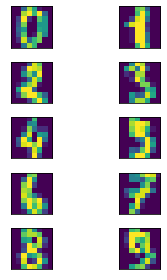

In [6]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# load data
digits_dataset = load_digits()

X = digits_dataset["data"]
y = digits_dataset["target"]

# split data (80% train and 20% test)
# training: 1437 samples, test: 360 samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

fig = plt.figure(figsize=(4, 4))
for i in range(10):
    image = digits_dataset.images[i]
    ax =  fig.add_subplot(5, 2, i+1)
    ax.imshow(image)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
plt.tight_layout()

[108**2 * RBF(length_scale=48.3) + WhiteKernel(noise_level=3.95e-07), 28.4**2 * RBF(length_scale=12.8) + WhiteKernel(noise_level=0.00099), 247**2 * RBF(length_scale=87.9) + WhiteKernel(noise_level=0.000995), 42.7**2 * RBF(length_scale=18.1) + WhiteKernel(noise_level=0.000991), 121**2 * RBF(length_scale=49.5) + WhiteKernel(noise_level=2.11e-07), 96.3**2 * RBF(length_scale=43.6) + WhiteKernel(noise_level=0.000994), 99.1**2 * RBF(length_scale=41.7) + WhiteKernel(noise_level=0.000995), 64.6**2 * RBF(length_scale=33.3) + WhiteKernel(noise_level=0.000994), 19.9**2 * RBF(length_scale=10.2) + WhiteKernel(noise_level=1.63e-07), 43.7**2 * RBF(length_scale=21) + WhiteKernel(noise_level=6.67e-07)]
acc = 97.78
f1 = [100.          98.24561404 100.          97.05882353 100.
  95.74468085  97.14285714  98.50746269  96.66666667  95.        ]


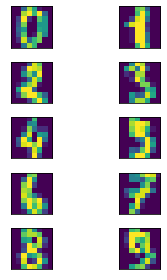

In [4]:
# scale data
scalerX = StandardScaler()
X_train_ = scalerX.fit_transform(X_train)

# construct GPC model

# scaled, isotropic RBF kernel with noise
kernel = ConstantKernel() * RBF(length_scale= 1., length_scale_bounds=(1e-03, 1e3)) 
kernel += WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-07, 5))

model = GaussianProcessClassifier(kernel)
model.fit(X_train_, y_train)

# print optimized hyperparameter values
params = model.kernel_.get_params()
print(params["kernels"])

# test model
y_pred = model.predict(scalerX.transform(X_test))

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average=None, labels=range(10)) * 100
print("acc = {:.2f}".format(acc))
print("f1 = {}".format(f1)) 